In [3]:
import torch
import numpy as np

import matplotlib.pyplot as plt

import torch.nn.functional as F

from torch import nn, optim

from torchvision import datasets, transforms

# Prepare data

In [2]:
# Define a transform to normalize the data
transform = transforms.Compose([transforms.ToTensor(),
                                transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
                               ])

# Download and load the training data
trainset = datasets.FashionMNIST("FashionMNIST_data/", download=True, train=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=64, shuffle=True)

# Download and load the test data
testset = datasets.FashionMNIST("FashionMNIST_data/", download=True, train=False, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=64, shuffle=True)

In [4]:
class Classifier(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(784, 256)
        self.fc2 = nn.Linear(256, 128)
        self.fc3 = nn.Linear(128, 64)
        self.fc4 = nn.Linear(64, 10)
    
    def forward(self, x):
        # make sure input tensor is flattened
        x = x.view(x.shape[0], -1)
        
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        x = F.log_softmax(self.fc4(x), dim=1)
        
        return x

In [5]:
model = Classifier()

images, labels = next(iter(testloader))

# Get the class probs
ps = torch.exp(model(images))

print(ps.shape)

torch.Size([64, 10])


In [10]:
top_p, top_class = ps.topk(1, dim=1)

print(top_class[:10, :])

tensor([[4],
        [4],
        [2],
        [4],
        [3],
        [4],
        [2],
        [2],
        [2],
        [4]])


In [11]:
equals = top_class == labels.view(*top_class.shape)

In [12]:
print(equals[:10, :])

tensor([[0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [1],
        [0],
        [0]], dtype=torch.uint8)


In [14]:
accuracy = torch.mean(equals.type(torch.FloatTensor))

print(f"Accuracy {accuracy.item() * 100} %")

Accuracy 14.0625 %


# Actually train the network

In [23]:
model = Classifier()
criterion = nn.NLLLoss()
optimizer = optim.Adam(model.parameters(), lr=0.003)

In [24]:
epochs = 30
steps = 0

train_losses, test_losses = [], []

for e in range(epochs):
    running_loss = 0
    for images, labels in trainloader:
        optimizer.zero_grad()
        
        log_ps = model(images)
        loss = criterion(log_ps, labels)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
    else:
        test_loss = 0
        accuracy = 0
        with torch.no_grad():
            for images, labels in testloader:
                log_ps = model(images)
                test_loss += criterion(log_ps, labels)
                
                ps = torch.exp(log_ps)
                top_p, top_class = ps.topk(1, dim=1)
                equals = top_class == labels.view(*top_class.shape)
                
                accuracy += torch.mean(equals.type(torch.FloatTensor))
                
        train_losses.append(running_loss / len(trainloader))
        test_losses.append(test_loss / len(testloader))
        
        print("Epoch: {}/{}..".format(e + 1, epochs))
        print("Training loss: {:.3f}".format(running_loss/len(trainloader)))
        print("Test loss: {:.3f}".format(test_loss/len(testloader)))
        print("Test Accuracy: {:.3f}".format(accuracy/len(testloader)))

Epoch: 1/30..
Training loss: 0.514
Test loss: 0.447
Test Accuracy: 0.840
Epoch: 2/30..
Training loss: 0.390
Test loss: 0.412
Test Accuracy: 0.847
Epoch: 3/30..
Training loss: 0.354
Test loss: 0.390
Test Accuracy: 0.857
Epoch: 4/30..
Training loss: 0.332
Test loss: 0.393
Test Accuracy: 0.858
Epoch: 5/30..
Training loss: 0.316
Test loss: 0.361
Test Accuracy: 0.871
Epoch: 6/30..
Training loss: 0.303
Test loss: 0.359
Test Accuracy: 0.876
Epoch: 7/30..
Training loss: 0.286
Test loss: 0.384
Test Accuracy: 0.864
Epoch: 8/30..
Training loss: 0.283
Test loss: 0.376
Test Accuracy: 0.873
Epoch: 9/30..
Training loss: 0.273
Test loss: 0.372
Test Accuracy: 0.872
Epoch: 10/30..
Training loss: 0.265
Test loss: 0.365
Test Accuracy: 0.872
Epoch: 11/30..
Training loss: 0.258
Test loss: 0.376
Test Accuracy: 0.877
Epoch: 12/30..
Training loss: 0.252
Test loss: 0.371
Test Accuracy: 0.873
Epoch: 13/30..
Training loss: 0.246
Test loss: 0.390
Test Accuracy: 0.876
Epoch: 14/30..
Training loss: 0.243
Test loss: 

In [25]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import matplotlib.pyplot as plt

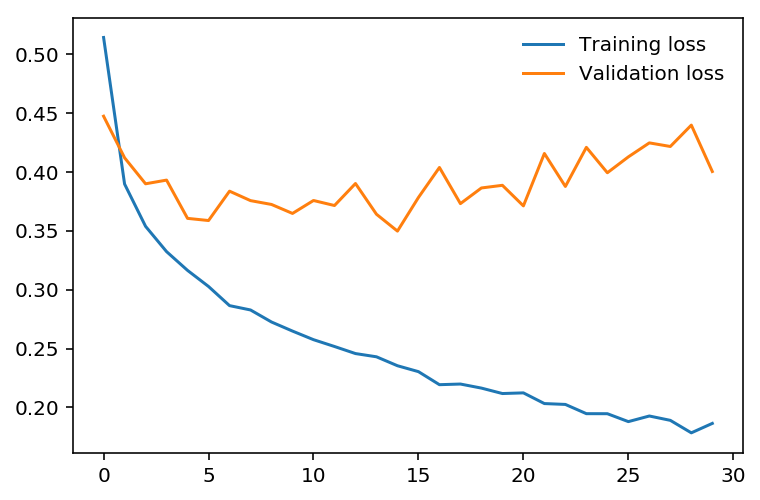

In [26]:
plt.plot(train_losses, label='Training loss')
plt.plot(test_losses, label='Validation loss')

plt.legend(frameon=False)

# Add DropOut

In [37]:
class ClassifierWithDropout(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(784, 256)
        self.fc2 = nn.Linear(256, 128)
        self.fc3 = nn.Linear(128, 64)
        self.fc4 = nn.Linear(64, 10)
    
        self.dropout = nn.Dropout(p=0.2)
    
    def forward(self, x):
        # make sure input tensor is flattened
        x = x.view(x.shape[0], -1)
        
        x = self.dropout(F.relu(self.fc1(x)))
        x = self.dropout(F.relu(self.fc2(x)))
        x = self.dropout(F.relu(self.fc3(x)))
        
        x = F.log_softmax(self.fc4(x), dim=1)
        
        return x

In [38]:
model = ClassifierWithDropout()
criterion = nn.NLLLoss()
optimizer = optim.Adam(model.parameters(), lr=0.003)

In [39]:
criterion = nn.NLLLoss()
optimizer = optim.Adam(model.parameters(), lr=0.003)

In [40]:
epochs = 10
steps = 0

train_losses, test_losses = [], []

for e in range(epochs):
    running_loss = 0
    for images, labels in trainloader:
        optimizer.zero_grad()
        
        log_ps = model(images)
        loss = criterion(log_ps, labels)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
    else:
        test_loss = 0
        accuracy = 0
        
        
        with torch.no_grad():
            #!Important: Change model to evaluation mode to deactivate dropout
            model.eval()
            
            for images, labels in testloader:
                
                log_ps = model(images)
                test_loss += criterion(log_ps, labels)
                
                ps = torch.exp(log_ps)
                top_p, top_class = ps.topk(1, dim=1)
                equals = top_class == labels.view(*top_class.shape)
                
                accuracy += torch.mean(equals.type(torch.FloatTensor))
            
            #!Important: Change model to training mode to activate dropout
            model.train()
            
            
        train_losses.append(running_loss / len(trainloader))
        test_losses.append(test_loss / len(testloader))
        
        print("Epoch: {}/{}..".format(e + 1, epochs))
        print("Training loss: {:.3f}".format(running_loss/len(trainloader)))
        print("Test loss: {:.3f}".format(test_loss/len(testloader)))
        print("Test Accuracy: {:.3f}".format(accuracy/len(testloader)))

Epoch: 1/10..
Training loss: 0.605
Test loss: 0.504
Test Accuracy: 0.818
Epoch: 2/10..
Training loss: 0.486
Test loss: 0.439
Test Accuracy: 0.846
Epoch: 3/10..
Training loss: 0.452
Test loss: 0.410
Test Accuracy: 0.856
Epoch: 4/10..
Training loss: 0.434
Test loss: 0.419
Test Accuracy: 0.848
Epoch: 5/10..
Training loss: 0.422
Test loss: 0.400
Test Accuracy: 0.857
Epoch: 6/10..
Training loss: 0.411
Test loss: 0.416
Test Accuracy: 0.853
Epoch: 7/10..
Training loss: 0.402
Test loss: 0.396
Test Accuracy: 0.862
Epoch: 8/10..
Training loss: 0.397
Test loss: 0.402
Test Accuracy: 0.863
Epoch: 9/10..
Training loss: 0.394
Test loss: 0.387
Test Accuracy: 0.866
Epoch: 10/10..
Training loss: 0.394
Test loss: 0.407
Test Accuracy: 0.850


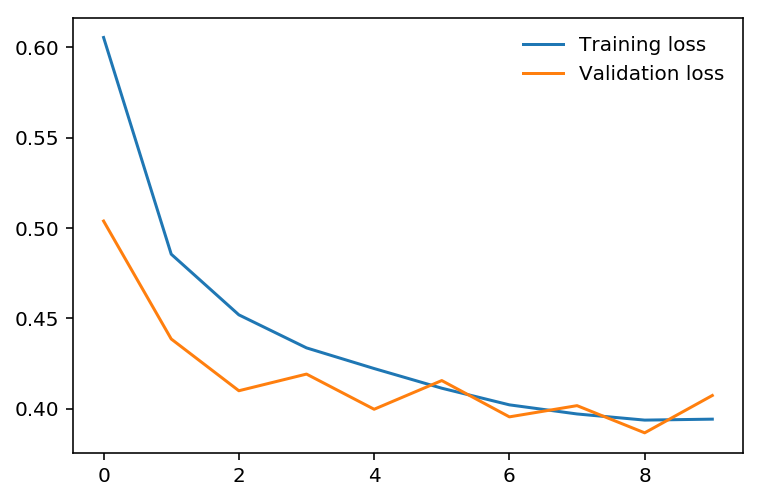

In [42]:
plt.plot(train_losses, label='Training loss')
plt.plot(test_losses, label='Validation loss')

plt.legend(frameon=False)

# Save and load model

In [43]:
print("Our model \n\n", model, "\n")

print("The state dict keys: \n\n", model.state_dict().keys())

Our model 

 ClassifierWithDropout(
  (fc1): Linear(in_features=784, out_features=256, bias=True)
  (fc2): Linear(in_features=256, out_features=128, bias=True)
  (fc3): Linear(in_features=128, out_features=64, bias=True)
  (fc4): Linear(in_features=64, out_features=10, bias=True)
  (dropout): Dropout(p=0.2)
) 

The state dict keys: 

 odict_keys(['fc1.weight', 'fc1.bias', 'fc2.weight', 'fc2.bias', 'fc3.weight', 'fc3.bias', 'fc4.weight', 'fc4.bias'])


In [44]:
torch.save(model.state_dict(), "checkpoint.pth")

In [45]:
state_dict = torch.load("checkpoint.pth")

In [47]:
print("state_dict \n", state_dict.keys())

state_dict 
 odict_keys(['fc1.weight', 'fc1.bias', 'fc2.weight', 'fc2.bias', 'fc3.weight', 'fc3.bias', 'fc4.weight', 'fc4.bias'])


In [48]:
model.load_state_dict(state_dict)

## Add information about the model so we can create the same architecture when using the checkpoint

In [52]:
checkpoint = {
    "input_size": 784,
    "output_size": 10,
    "state_dict": model.state_dict()
}

torch.save(checkpoint, "checkpoint.pth")

In [53]:
ck_data = torch.load("checkpoint.pth")

In [54]:
ck_data.keys()

dict_keys(['input_size', 'output_size', 'state_dict'])